##  <font color= darkblue>  Predicting Prospects  Score Intent</font>##

### <font color=darkgreen>Problem Defenition</font> ###

Company XYZ sells routers to companies. They have a database with information about all sales prospects they got in touch with in 2015. Some of these people became customers (i.e.  bought at least one router) and some didn't end up buying. Therefore, we want to Build a model which assigns to each prospect in the Prospects table the probability of becoming a customer. We will call this score "intent". 

**Importing Packages**

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk
import statistics as stat
import datetime as dt
import seaborn as sns

**Loading Data**

In [3]:
#Load Prospects & Sales tables
Prospects= pd.read_excel("Prospects.xlsx")
Sales= pd.read_excel("Sales.xlsx")

**Exploring Prospects Table**

Prospects table contains general information about prospects and the company they work for 

**Columns:**
- **user_id**: the id of the prospect. Unique by prospect. Can be joined to user_id in 
the other table 
- **company_sector**: the sector in which the company operates, i.e. public administration, finance and insurance, healthcare, etc. 
- **company_size**: number of employees 
-  **DMU_role**: Decision Making Unit role of this employee, i.e. Influencer, Budget Holder, Decision Maker...  
- **joining_date**: when the prospect joined the company 
- **country**: country where the prospect is based   

In [4]:
# Total Prospects, e.g. Number of rows 
print 'Total Prospects: ',len(Prospects)

#Total Unique Prospects
print'Total Unique Prospects: ',len(Prospects.user_id.unique())

# First 5 Rows
Prospects.head()

Total Prospects:  2999
Total Unique Prospects:  2995


,user_id,company_sector,company_size,DMU_final,joining_date,country
0,0018000000uEraqAAC,Finance and Insurance,10,End User,2010-04-13,FRANCE
1,0018000000qlc1RAAQ,Public Administration,1,End User,2004-09-22,FRANCE
2,0018000000uI1MjAAK,"Professional, Scientific, and Technical Services",10,End User,2013-06-09,FRANCE
3,0018000000qlsFyAAI,Information,15,End User,2003-02-25,FRANCE
4,0018000000qnZ05AAE,Wholesale Trade,10,End User,2009-11-16,FRANCE


**Dealing with Prospects Duplicates**

In [5]:
# Viewing duplicates user_id's
Prospects[Prospects.duplicated(['user_id'], keep=False)].sort_values('user_id')
print 'Before duplicates removal:','\n'

# Total Prospects Before removing duplicates, e.g. Number of rows 
print 'Total Prospects: ',len(Prospects)

#Total Unique Prospects Before removing duplicates
print'Total Unique Prospects: ',len(Prospects.user_id.unique()),'\n\n'

# removing duplicates user_id's to prevent misleading information bias
duplicatesUsers=Prospects[Prospects.duplicated(['user_id'], keep=False)]['user_id'].unique()
Prospects.drop_duplicates(subset='user_id', keep=False, inplace=True)
print 'After duplicates removal: ','\n'

# Total Prospects, e.g. Number of rows 
print 'Total Prospects: ',len(Prospects)

#Total Unique Prospects
print 'Total Unique Prospects: ',len(Prospects.user_id.unique())

Before duplicates removal: 

Total Prospects:  2999
Total Unique Prospects:  2995 


After duplicates removal:  

Total Prospects:  2991
Total Unique Prospects:  2991


** Exploring Sales Table**

**Sales table** contains all information about the 2015 sales funnel Columns: 
- **user_id**: the id of the prospect. Unique by prospect. Can be joined to user_id in the other table 
- **date_first_contact**: first time company XYZ got in touch with that given prospect 
- **source**: how company XYZ firstly connected with that given prospect. That is: 
email marketing, organic search, referral etc. 
- **linkedin_shared_connections**: number of shared connections on LinkedIn between prospect and company XYZ sale representatives 
- **online_activity**: a score between 5 and 685 of this prospect’s online activity on groups related to routers on LinkedIn/FB/Twitter. The higher this value, the more active the prospect is on social network discussions about routers  
- **did_buy** : binary variable to be used as a label in the model. 0 means no sale, 1 means the prospect bought at least 1 router in 2016.

In [6]:
# Total Sales, e.g. Number of rows 
print'Total Sales: ',len(Sales)

#Total Unique Sales
print'Total Unique Sales: ',len(Sales.user_id.unique()) # Gap because of duplicated Prospects

#Total Unique Sales without duplicated Prospects
print'Total Unique Sales without duplicated Prospects: ',len(Sales[~Sales['user_id'].isin(duplicatesUsers)])

# First 5 Rows
Sales.head()

Total Sales:  2999
Total Unique Sales:  2995
Total Unique Sales without duplicated Prospects:  2991


,user_id,date_first_contact,Original Source Type,linkedin_shared_connections,online_activity,did_buy,sale_date
0,0018000000uEraqAAC,2016-01-09,Referrals,11,65,1,2016-05-23
1,0018000000qlc1RAAQ,2015-12-21,Social Media,13,65,1,2016-01-12
2,0018000000uI1MjAAK,2014-10-18,Email Marketing,4,95,1,2016-05-30
3,0018000000qlsFyAAI,2016-03-31,Organic Search,0,65,1,2016-07-28
4,0018000000qnZ05AAE,2016-02-05,Other Campaigns,3,65,1,2016-06-17


** Merging Prospects & Sales**

Since we want to build a model to predict if a prospect is going to buy, we will determine the granularity of the new merged table by **Prospects**.

In [7]:
# Merging Table by user id
fullData=pd.merge(Prospects,Sales, how='inner', on='user_id')

# Total Prospects, e.g. Number of rows 
print'Total Prospects: ',len(fullData)

# Total Unique Prospects
print'Total Unique Prospects: ',len(fullData.user_id.unique())

# First 5 rows
fullData.head()

Total Prospects:  2991
Total Unique Prospects:  2991


,user_id,company_sector,company_size,DMU_final,joining_date,country,date_first_contact,Original Source Type,linkedin_shared_connections,online_activity,did_buy,sale_date
0,0018000000uEraqAAC,Finance and Insurance,10,End User,2010-04-13,FRANCE,2016-01-09,Referrals,11,65,1,2016-05-23
1,0018000000qlc1RAAQ,Public Administration,1,End User,2004-09-22,FRANCE,2015-12-21,Social Media,13,65,1,2016-01-12
2,0018000000uI1MjAAK,"Professional, Scientific, and Technical Services",10,End User,2013-06-09,FRANCE,2014-10-18,Email Marketing,4,95,1,2016-05-30
3,0018000000qlsFyAAI,Information,15,End User,2003-02-25,FRANCE,2016-03-31,Organic Search,0,65,1,2016-07-28
4,0018000000qnZ05AAE,Wholesale Trade,10,End User,2009-11-16,FRANCE,2016-02-05,Other Campaigns,3,65,1,2016-06-17


** Handeling Missing Values**

As we can see below, **Sale Date** has 257 missing values, while the rest haven't. Moreover, we can say that sale date missing values represents the prospects who didn't buy in the past, therefore, we can say that Sale Date has a functional dependency with Did Buy. As a result, Sale Date will be removed.

In [8]:
# Printing Columns with missing values
NullColumns=pd.DataFrame(fullData.isnull().sum(),columns=['Missing Values'])
print NullColumns

# Print total missing values
print'\n',"Total Null's Values: ",fullData.isnull().sum().sum()

                             Missing Values
user_id                                   0
company_sector                            0
company_size                              0
DMU_final                                 0
joining_date                              0
country                                   0
date_first_contact                        0
Original Source Type                      0
linkedin_shared_connections               0
online_activity                           0
did_buy                                   0
sale_date                               257

Total Null's Values:  257


## <font color='darkgreen'>Data Exploration & Preparation</font> ##

### Exploring Did Buy (Target)###

Target Distribution:
         user_id
did_buy         
1           2728
0            263 

Normalized Target Distribution:
     did_buy
1  91.206954
0   8.793046


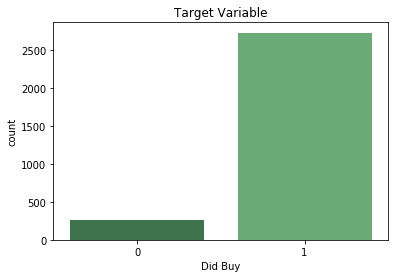

In [9]:
print'Target Distribution:'
TD=fullData.groupby('did_buy').count()
targetDist=pd.DataFrame(TD['user_id'].sort_values(ascending=False))
print targetDist,'\n'

# Printing Target Distribution Ratio (%)
targetRatio=pd.DataFrame(pd.value_counts(fullData['did_buy'])/fullData['did_buy'].count()*100)
targetRatio.columns
print 'Normalized Target Distribution:'
print targetRatio

# Plotting Target Variable 
sns.countplot(x="did_buy", data=fullData, palette="Greens_d")
plt.title('Target Variable')
plt.xlabel('Did Buy')
plt.show()

By exploring target variable, we can see above that we are dealing with imbalanced class problem: 

** - Majority class: '1' : 2728 (91.2%)**

** - Minority class: '0' : 263  (8.8 %)**

As a result, we should consider some imbalancing data techniques like: Up Sampling, Down Sampling, SMOTE, etc.

** Exploring Numeric Features**

Descriptive Statistics for Company Size, Linkedin Shared Connections & Online Activity. Moreover, a correlogram is added in order to see the interactions and distributions of each one.

In [10]:
# Descriptive Statistics for Company Size, Linkedin Shared Connections & Online Activity
fullData[['company_size','linkedin_shared_connections','online_activity']].describe()

,company_size,linkedin_shared_connections,online_activity
count,2991.000000,2991.000000,2991.000000
mean,499.696423,9.423938,53.741224
std,5903.189696,6.432527,64.601391
min,0.000000,0.000000,5.000000
25%,6.000000,4.000000,15.000000
50%,22.000000,9.000000,40.000000
75%,93.000000,14.000000,70.000000
max,135300.000000,38.000000,685.000000


** Correlation Matrix on numeric features only**

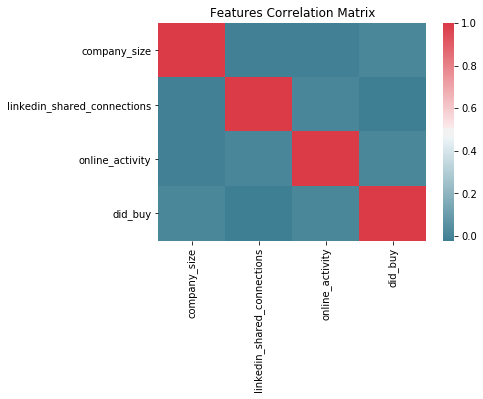

In [11]:
#Calculating correlation on numeric features
corr = fullData.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Plot Correlation Matrix
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns, cmap=cmap)
plt.title('Features Correlation Matrix')
plt.show()

On the correlation matrix above, we can see that are around 20% positive correlation between Company Size and Did Buy, Linkedin Shared Connections and Online Activity and last, Online Activity and Did Buy. Therefore, we can assume the following:


1. **Company Size** <font color=blue>$\uparrow$</font>  $\rightarrow$ **Probability to buy** <font color=blue>$\uparrow$</font>
2. **Online Activity**<font color=blue> $\uparrow$ </font>  $\rightarrow$ **Linkedin Shared Connections**<font color=blue> $\uparrow$</font>
3. **Online Activity** <font color=blue> $\uparrow$ </font> $\rightarrow$ **Probability to buy** <font color=blue>$\uparrow$</font>


### Data Preparation###

Some of the features aren't relevant or not defined in a suitable way for training phase. As a result, some methods needed to be considered in order to make features more useful. Therefore, I used transformation, casting and encoding. In addition, I removed some of the features after transformation step. 

In [12]:
# Current data types status
print'Features Data Types:'
fullData.dtypes

Features Data Types:


user_id                                object
company_sector                         object
company_size                            int64
DMU_final                              object
joining_date                   datetime64[ns]
country                                object
date_first_contact             datetime64[ns]
Original Source Type                   object
linkedin_shared_connections             int64
online_activity                         int64
did_buy                                 int64
sale_date                      datetime64[ns]
dtype: object

**Feature Engineering**

In [13]:
from sklearn import preprocessing

# Transformed Data Creation
transformedData=fullData
print'Feature Types before transformation: ','\n',transformedData.dtypes,'\n'

# Casting Catagorical Features & Target using One-hot encoding
categoricalFeatures=['company_sector','DMU_final','country','Original Source Type']
for column in categoricalFeatures:
    
    # Cast to categorical
    transformedData[column] = transformedData[column].astype('category') 
    
    # Create one-hot encoder
    one_hot = preprocessing.LabelBinarizer()
        
    # One-hot encode feature
    transformedData[column] =  one_hot.fit_transform(transformedData[column])


# transforming columns:

# Joining Date is splited by year, month & day
transformedData['joining_year'] = transformedData['joining_date'].dt.year
transformedData['joining_month'] = transformedData['joining_date'].dt.month
transformedData['joining_day'] = transformedData['joining_date'].dt.day

# Date First Contact is splited by year, month & day
transformedData['year_first_contact '] = transformedData['date_first_contact '].dt.year
transformedData['month_first_contact '] = transformedData['date_first_contact '].dt.month
transformedData['day_first_contact '] = transformedData['date_first_contact '].dt.day

#Viewing Current Data State & Types
transformedData.head()
print'Feature Types after transformation: ','\n',transformedData.dtypes,'\n'


# Removing columns: user_id, joining_date, day_first_contact, sale_date
cleansedData=transformedData.drop(['joining_date','date_first_contact ','sale_date'], axis=1)
print'Cleansed Data Size: ',len(cleansedData.index)

# Viewing cleansed data first 5 rows
cleansedData.head()

Feature Types before transformation:  
user_id                                object
company_sector                         object
company_size                            int64
DMU_final                              object
joining_date                   datetime64[ns]
country                                object
date_first_contact             datetime64[ns]
Original Source Type                   object
linkedin_shared_connections             int64
online_activity                         int64
did_buy                                 int64
sale_date                      datetime64[ns]
dtype: object 

Feature Types after transformation:  
user_id                                object
company_sector                          int32
company_size                            int64
DMU_final                               int32
joining_date                   datetime64[ns]
country                                 int32
date_first_contact             datetime64[ns]
Original Source Type             

,user_id,company_sector,company_size,DMU_final,country,Original Source Type,linkedin_shared_connections,online_activity,did_buy,joining_year,joining_month,joining_day,year_first_contact,month_first_contact,day_first_contact
0,0018000000uEraqAAC,0,10,0,1,0,11,65,1,2010,4,13,2016,1,9
1,0018000000qlc1RAAQ,0,1,0,1,0,13,65,1,2004,9,22,2015,12,21
2,0018000000uI1MjAAK,0,10,0,1,1,4,95,1,2013,6,9,2014,10,18
3,0018000000qlsFyAAI,0,15,0,1,0,0,65,1,2003,2,25,2016,3,31
4,0018000000qnZ05AAE,0,10,0,1,0,3,65,1,2009,11,16,2016,2,5


We can see at the correlogram below that Linkedin shared Connections distribution looks similar to the Normal Distribution but, without left tale. However, Company Size and Online Activity are asymmetrical and right tailed. Moreover, by looking on the interaction between Company Size and Online Activity, we can notice that for prospects who belongs to companies with large number of employees have less online activity.

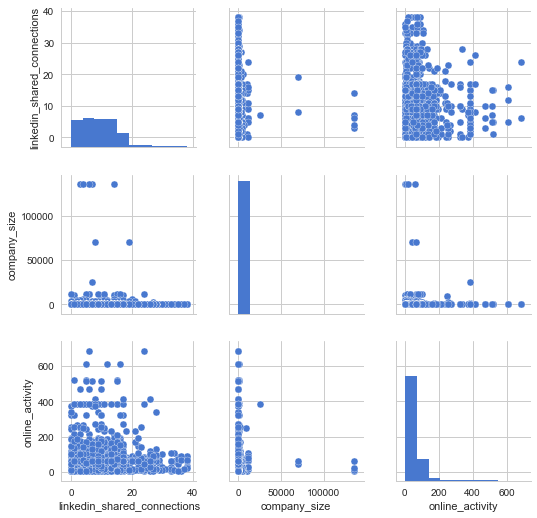

In [14]:
# Basic correlogram
sns.set(style="whitegrid", palette="muted")
sns.pairplot(cleansedData[['linkedin_shared_connections', 'company_size', 'online_activity']])
plt.show()

**Features Normalization**

In [15]:
# Removing User ID from features
finalData=pd.DataFrame(cleansedData.drop('user_id', axis=1))
Features=finalData

# Preparing features for scaling
preScale=pd.DataFrame(Features.drop(['online_activity','DMU_final','company_size',
                                     'company_sector','country','Original Source Type','did_buy'], axis=1))

# Create standardizer
min_max_scaler = sk.preprocessing.MinMaxScaler()

# Feature Normalization 
Features_scaling = min_max_scaler.fit_transform(preScale)
Scaled_Features=pd.DataFrame(Features_scaling,columns=preScale.columns)
Scaled_Features['did_buy']=finalData.did_buy
df = pd.DataFrame(Scaled_Features)

### Features Exploration ###

#### Characteristics of High Intent vs. Low Intent Prospects####

**Online Activity** distributed by prospects who bought in the past and prospects that didn't, represented by Boxplot. We can see that median online activity value is little bit lower among prospects whou bought in the past. However, we can notice that there are much more outliers among prospects who bought in the past and therefore, the average of prospects whou bought in the past is slightly bigger than the rest because it's more sensitive to ouliers.

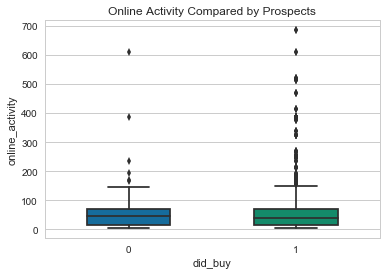

In [16]:
OA_bplot=sns.boxplot(y='online_activity', x='did_buy', 
                 data=Features, 
                 width=0.5,
                 palette="colorblind")
plt.title('Online Activity Compared by Prospects')
plt.show()

**Radar Charts** 

Are used for displaying multivariate data in the form of n-dimensional quantitative variables represented on axes, and starting from the same point('Normalized'). While looking on the Radar Chart above, means of<font color=green> prospects who bought in the past</font> are compared to means of<font color=blue> prospects who didn't buy</font> by few quantitive features.

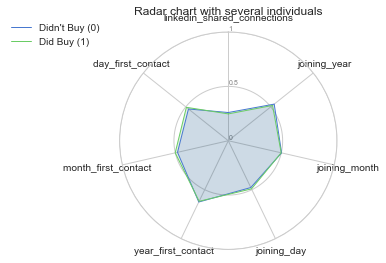

In [17]:
# Libraries
from math import pi

# number of variable
categories=list(df)[:7]
N = len(categories)

# Create background

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0,0.5,1], ["0","0.5","1"], color="grey", size=7)
plt.ylim(0,1)

 
# Add plots
 
# Separate prospects who bought and didn't. Calculating each population average 
Did_Buy = df[df.did_buy==1].mean()
Did_Not_Buy = df[df.did_buy==0].mean()


# Didn't Buy blanket
values=Did_Not_Buy.drop('did_buy').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Didn't Buy (0)")
ax.fill(angles, values, 'blue', alpha=0.1)
 
# Did Buy blanket
values=Did_Buy.drop('did_buy').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Did Buy (1)")
ax.fill(angles, values, 'green', alpha=0.1)
 
# Add legend
plt.legend(loc='best', bbox_to_anchor=(-0.05, 1.08))
plt.title('Radar chart with several individuals',loc='center')
plt.show()

While looking on both sampled groups we can see that blankets are almost the same. However, we can conclude the following;

1. Joining month and first contact year means are almost identical between groups. 
2. Linkedin share connections and Joining year means are little bit higher among <font color=blue> prospects who didn't buy </font> in the past.
3. First contact month, First contact day and Joining day means are little bit higher among <font color=green> prospects who bought </font> in the past.

However, in order to perform a more qualitative and accurate comparison between the two groups based on their features, statistical tests between the two populations were conduct for each quantitative feature. Moreover, we used these following tests (considering significance level of 5%) :


1. **The independent samples t test** - Compare the means of two sets of data under some assumptions:
     
    <p>&nbsp; &nbsp; 1.1 **Assumption of Independence**: two independent, categorical groups that represent your independent variable. </p> 
    <p>&nbsp; &nbsp; 1.2 **Assumption of normality**: the dependent variable should be approximately normally distributed and also be measured on a continuous scale. </p>
    <p>&nbsp; &nbsp; 1.3 **Assumption of Homogeneity of Variance**: The variances of the dependent variable should be equal.</p> 
</p>
<p>&nbsp; &nbsp; 
2. **The Mann–Whitney U test** - A nonparametric test of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample. Unlike the t-test it does not require the assumption of normal distributions. <p>

In [18]:
from scipy import stats
from math import sqrt
from scipy.stats import t

# Preparing data for t independent 
df = pd.DataFrame(Features.drop(['DMU_final','company_sector','country','Original Source Type'], axis=1))

# Split data by Did buy
Did_Buy = df[df.did_buy==1].drop('did_buy',axis=1)
Did_Not_Buy = df[df.did_buy==0].drop('did_buy',axis=1)

# for each quantitive column run statistical tests
for column in Did_Buy.columns:
    if Did_Buy[column].mean()>Did_Not_Buy[column].mean():
        
        print column,': Did buy mean > Did not buy mean','\n'
        
        # Run independent t-test 
        ind_t_test = stats.ttest_ind(Did_Buy[column],Did_Not_Buy[column])
        diff_mean = Did_Buy[column].mean() - Did_Not_Buy[column].mean()
        
        # Run Mann–Whitney U test
        ind_sign_test=stats.ranksums(Did_Buy[column],Did_Not_Buy[column])
        
    else: 
        
        print column,': Did not buy mean > Did buy mean','\n'
        
        # Run independent t-test
        ind_t_test = stats.ttest_ind(Did_Not_Buy[column],Did_Buy[column])
        diff_mean = Did_Not_Buy[column].mean() - Did_Buy[column].mean()
        
        # Run Mann–Whitney U test
        ind_sign_test=stats.ranksums(Did_Not_Buy[column],Did_Buy[column])

    # Calculate the mean difference and 95% confidence interval
    N_Did = len(Did_Buy[column])
    N_Didnt = len(Did_Not_Buy[column])
    DOF = (N_Did + N_Didnt - 2)
    std_Did = Did_Buy[column].std()
    std_Didnt = Did_Not_Buy[column].std()
    std_N1N2 = sqrt(((N_Did - 1)*(std_Did)**2 +(N_Didnt - 1)*(std_Didnt)**2) / DOF) 

    
    # Calculate Mean of Error
    MoE = float(stats.t.ppf(0.975, DOF) * std_N1N2 * float(sqrt(1/float(N_Did) + 1/float(N_Didnt))))
    

    #CI
    LB = float(diff_mean - MoE)
    UB= diff_mean + MoE
    
    print 'The results of the independent t-test are: \n\tt-value = {:4.3f}\n\tp-value = {:4.3f}'.format(ind_t_test[0],ind_t_test[1])
    print 'The difference between groups is {:.3f} [{:.3f} to {:.3f}] (mean [95% CI])'.format(diff_mean, LB , UB),'\n'
    print 'The results of the Mann–Whitney (Wilcoxon rank-sum) test are: \n\tU-value = {:.3f}\n\tp-value = {:.3f}'.format(ind_sign_test[0],ind_sign_test[1]),'\n\n'

company_size : Did buy mean > Did not buy mean 

The results of the independent t-test are: 
	t-value = 0.596
	p-value = 0.551
The difference between groups is 227.120 [-520.302 to 974.541] (mean [95% CI]) 

The results of the Mann–Whitney (Wilcoxon rank-sum) test are: 
	U-value = 2.361
	p-value = 0.018 


linkedin_shared_connections : Did not buy mean > Did buy mean 

The results of the independent t-test are: 
	t-value = 1.149
	p-value = 0.250
The difference between groups is 0.477 [-0.337 to 1.292] (mean [95% CI]) 

The results of the Mann–Whitney (Wilcoxon rank-sum) test are: 
	U-value = 1.112
	p-value = 0.266 


online_activity : Did buy mean > Did not buy mean 

The results of the independent t-test are: 
	t-value = 0.704
	p-value = 0.482
The difference between groups is 2.935 [-5.245 to 11.114] (mean [95% CI]) 

The results of the Mann–Whitney (Wilcoxon rank-sum) test are: 
	U-value = -0.484
	p-value = 0.628 


joining_year : Did not buy mean > Did buy mean 

The results of the 

By viewing the above statistics results, we can see that there aren't enough observations to reject the null hypotesis with significance level of 5%, However, we have enough observations to reject the null hypotesis and conclude that **Company Size mean among prospects who bought in the past is higher** then prospects who didn't buy, with significance level of 5%.


**Company Size :**
\begin{align}
\bar{X}_{Did Bought} > \bar{X}_{Did Not Buy}\quad (\alpha = 5\%)
\end{align}


The results of the Wilcoxon rank-sum test ($\alpha$ = 0.05) are: 
- U-value = 2.361
- p-value = 0.018 
    

**Splitting to Test and Train Datasets**

In [19]:
from sklearn import model_selection
#Splitting to Test and Train Data
X_train, X_test, y_train, y_test = model_selection.train_test_split(finalData.loc[:, finalData.columns != 'did_buy'],
                                                                       finalData['did_buy'], test_size=0.2,random_state=42) 
# Printing Dimensions                                                                    
print 'Training Set Dimensions:','\n','X = ',X_train.shape,' Y = ', y_train.shape,'\n'
print 'Test Set Dimensions:','\n','X = ',X_test.shape,' Y = ', y_test.shape,'\n'

print'Train Target Distribution','\n'
print y_train.value_counts(),'\n'

print 'Test Target Distribution','\n'
print y_test.value_counts()

Training Set Dimensions: 
X =  (2392, 13)  Y =  (2392L,) 

Test Set Dimensions: 
X =  (599, 13)  Y =  (599L,) 

Train Target Distribution 

1    2179
0     213
Name: did_buy, dtype: int64 

Test Target Distribution 

1    549
0     50
Name: did_buy, dtype: int64


## <font color='darkgreen'>Modeling & Evaluation</font> ##


Since we are dealing with classification problem of binary target variable (Did buy) and moreover, features are numeric, integers, and categorical. Therefore, algorithms like Logistic Regression, Random Forest, KNN, etc. can be useful here. 

At the cell below, **Logitic Regression, Decision Trees, KNN, Naïve Bayes, SVM & Neural Net **are being compared by a cross validation procedure with Area Under Curve scoring metric.

LR: Accuracy: 0.910961 (std: 0.015725)
KNN: Accuracy: 0.903431 (std: 0.016127)
CART: Accuracy: 0.836104 (std: 0.021417)
NB: Accuracy: 0.854533 (std: 0.026267)
SVM: Accuracy: 0.910961 (std: 0.015725)
Neural Net: Accuracy: 0.897592 (std: 0.027938)


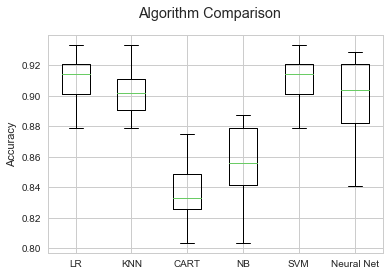

In [20]:
# Different Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

        
# Preparing For Cross Validation
X = X_train
Y = y_train
 
# prepare configuration for cross validation test harness
seed = 42

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('Neural Net', MLPClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = sk.model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = sk.model_selection.cross_val_score(model, X, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: Accuracy: %f (std: %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel('Accuracy')
plt.show()

By comparing any of the algorithms above, we can see that best performed classifiers are:
- **Logistic Regression **
- **K-Nearest Neighbors ** 
- **Support Vector Machine ** 
- **Neural Net ** 




### Created Functions that are used later### 

**Plotting Confusion Matrix**

In [21]:
# Plotting Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    import itertools
    #from itertools import product
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

** Logistic Regression Hyperparameter Tuning using Grid Search Cross Validation **

In [22]:
# Hyperparameter Tuning using Grid Search Cross Validation 
def Hyperparameter_Tuning_LR(X_train,y_train,random_state=42):
    import sklearn as sk
    # Create logistic regression
    logistic = sk.linear_model.LogisticRegression(random_state=random_state)

    # Create regularization penalty space
    penalty = ['l1', 'l2']

    # Create regularization hyperparameter space
    C = np.logspace(0, 4, 10)

    # Create class weight hyperparameter space
    #CW=[{0:0.67, 1:0.33},{0:0.75, 1:0.25} ,{0:0.8, 1:0.2},{0:0.9, 1:0.1},{0:0.91, 1:0.89},'balanced'] #expected 2:1

    # Create hyperparameter options
    hyperparameters = dict(C=C, penalty=penalty)#,class_weight=CW)

    # Create grid search using 5-fold cross validation
    clf = sk.model_selection.GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

    # Fit grid search
    best_LR_model = clf.fit(X_train, y_train)

    # View best hyperparameters
    print 'Best Penalty:', best_LR_model.best_estimator_.get_params()['penalty']
    print 'Best C:', best_LR_model.best_estimator_.get_params()['C']
    #print('Best Class_weight:', best_LR_model.best_estimator_.get_params()['class_weight'])

**Tuning Logistic Regression Class Weight **

In [23]:
# Function compares different binary class weights based on AUC metric. Finally, Plotting AUC by minority class weight
def Compare_AUC_Class_Weight(X_train,y_train,X_test,y_test,penalty='l1',C=1):
    import pandas as pd
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression

    # Comparing between different class weight
    j=0
    LR_AUC_table = pd.DataFrame(columns = ['minority_class_weight','AUC'])
    for i in np.arange(0.05, 1, 0.05):

        # all parameters not specified are set to their defaults
        logisticRegr = LogisticRegression(penalty=penalty,C=C ,class_weight={0:i, 1:(1-i)},random_state=42)
        logisticRegr.fit(X_train, y_train)

        # Predictions
        y_pred=logisticRegr.predict(X_test)

        # Saving AUC score in table
        LR_AUC_table.at[j, 'minority_class_weight']  = i
        LR_AUC_table.at[j, 'AUC'] = sk.metrics.roc_auc_score(y_test, y_pred)
        j+=1


    # Plotting AUC Comparison 
    ax=LR_AUC_table.plot('minority_class_weight','AUC',xticks=np.arange(0.05, 1, 0.05),figsize=(10,4))
    ax.set_ylabel("AUC")
    ax.set_xlabel("minority_class_weight")
    plt.show()

** Finds Best K By Area Under Curve**

In [24]:
def finding_best_K(X_train,y_train, X_test,y_test,max_k=50):
    from sklearn import neighbors
    # Comparing between different K's
    j=0
    KNN_AUC_table = pd.DataFrame(columns = ['K','AUC'])
    for k in range(1,max_k):
        # Train a KNN classifier with 5 neighbors
        knn = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1).fit(X_train, y_train)

        # Prediction on test data
        y_pred = knn.predict(X_test)

        # Saving AUC score in table
        KNN_AUC_table.at[j, 'K']  = k
        KNN_AUC_table.at[j, 'AUC'] = sk.metrics.roc_auc_score(y_test, y_pred)
        j+=1

    print 'Max AUC: ',KNN_AUC_table['AUC'].max(),' Best K: ',KNN_AUC_table['K'][KNN_AUC_table['AUC'].values.argmax()]
    # Plotting AUC Comparison 
    ax=KNN_AUC_table.plot('K','AUC',xticks=range(1,max_k),figsize=(10,4))
    ax.set_ylabel("AUC")
    ax.set_xlabel("K")
    plt.show()

** Random Forest Hyperparameter Tuning using randomized Search Cross Validation **

In [25]:
# Hyperparameter tuning for Random Forest by a given train set. 
def Random_Forest_Hyperparameter_Tuning(X_train, y_train):
    from sklearn.model_selection import RandomizedSearchCV

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}


    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()

    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Best Random Forest Down Sampling Configuration
    print rf_random.best_params_

**Find Best Random Forest Probability Treshold**

In [26]:
def find_Best_RF_Treshold(y_pred):
    import sklearn as sk
    j=0
    RF_AUC_table = pd.DataFrame(columns = ['Probability Treshold','AUC'])

    # Compare between tresholds
    for i in np.arange(0.5, 0.95, 0.005):

        # Finding best probability treshold
        predictions=y_pred.copy() 
        predictions[predictions > i] = 1
        predictions[predictions <= i] = 0

        # Compute confusion matrix based on selected treshold
        cnf_matrix = sk.metrics.confusion_matrix(y_test, predictions)
        np.set_printoptions(precision=2)

        # Saving AUC score in table
        RF_AUC_table.at[j, 'Probability Treshold']  = i
        RF_AUC_table.at[j, 'AUC'] = sk.metrics.roc_auc_score(y_test, predictions)
        j+=1


    # Plotting AUC Comparison 
    ax=RF_AUC_table.plot('Probability Treshold','AUC',xticks=np.arange(0.5, 0.95, 0.005),figsize=(10,4))
    ax.set_ylabel("AUC")
    ax.set_xlabel("Probability Treshold")
    plt.show()

    #Print results
    print 'Max AUC: ',RF_AUC_table['AUC'].max(),' Probability Treshold: ',RF_AUC_table.loc[RF_AUC_table.AUC.values.argmax(), 'Probability Treshold']

** Prints Classification Report, Accuracy & Area Under curve**

In [27]:
# Prints classification reports, accuracy & Area Under curve based on a given Test Target (y_test) & Predictions(y_pred).
def print_class_matrics(y_test, y_pred):
    from sklearn import metrics
    print metrics.classification_report(y_test, y_pred)
    print 'Accuracy: ',sk.metrics.accuracy_score(y_test, y_pred)*100 ,'%'
    print'AUC: ',sk.metrics.roc_auc_score(y_test, y_pred)*100,'%'

** Creates AUC Scoring Function**

In [28]:
# define scoring function 
def custom_auc(ground_truth, predictions):
    # Importing packages
    from sklearn import metrics
    
    # I need only one column of predictions["0" and "1"]. You can get an error here   
    return metrics.roc_auc_score(ground_truth, predictions)*100
    
# to be standart sklearn's scorer        
AUC_Scorer = sk.metrics.make_scorer(custom_auc, greater_is_better=True, needs_proba=False)

#### <font color=blue> Logistic Regression </font>

Hyperparameter tuning to find best configuration for Logistic Regression models.

In [29]:
# Hyperparameter Tuning using Grid Search Cross Validation   
Hyperparameter_Tuning_LR(X_train,y_train,42)

Best Penalty: l1
Best C: 1.0


Since the best picked configuration classify all test data points as '1', we want to find best Class Weight for maximizing the Area Under Curve.

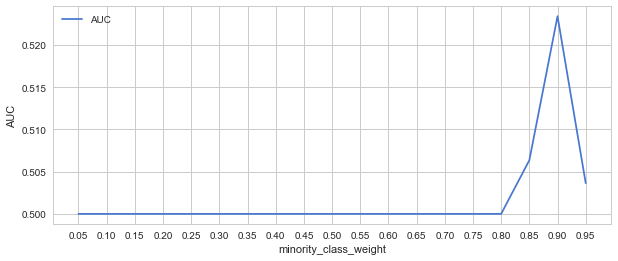

In [30]:
# Plotting AUC by class weight
Compare_AUC_Class_Weight(X_train,y_train,X_test,y_test,penalty='l1',C=1)

Selecting best configuration.

Optimized Logistic Regression 

             precision    recall  f1-score   support

          0       0.10      0.28      0.15        50
          1       0.92      0.77      0.84       549

avg / total       0.85      0.73      0.78       599

Accuracy:  72.62103505843072 %
AUC:  52.342440801457194 %


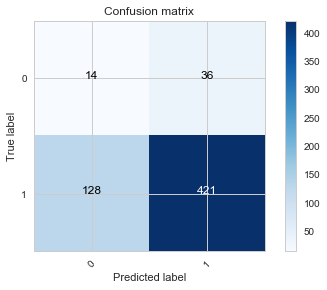

In [31]:
# Selecting Best Class Weight {0:0.9,1:0.1}

# Adjusting LR Model based on best configuration
logisticRegr = LogisticRegression(penalty='l1', C=1, class_weight={0:0.9, 1:0.1},random_state=42)
logisticRegr.fit(X_train, y_train)

# Predictions
y_pred=logisticRegr.predict(X_test)

# Computing confusion matrix
cnf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

# Print Metrics
print 'Optimized Logistic Regression','\n'
print_class_matrics(y_test, y_pred)
plt.show()

**Upsampling**

Hyperparameter tuning to find best configuration for Logistic Regression models.

In [32]:
from sklearn.utils import resample

#Splitting to Test and Train Data
train, test = sk.model_selection.train_test_split(finalData, test_size=0.2,random_state=42) 

# Separate majority and minority classes
train_majority = train[train.did_buy==1]
train_minority = train[train.did_buy==0]

 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2179,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Display new class counts
print train_upsampled.did_buy.value_counts()

# Balanced Data
# 0    2179
# 1    2179

#Re-Splitting Data 
y_train_US=train_upsampled.did_buy
X_train_US=train_upsampled.drop('did_buy', axis=1)
y_test=test.did_buy
X_test=test.drop('did_buy',axis=1)

# Hyperparameter Tuning using Grid Search Cross Validation   
Hyperparameter_Tuning_LR(X_train_US,y_train_US)

1    2179
0    2179
Name: did_buy, dtype: int64
Best Penalty: l2
Best C: 3593.813663804626


Finding best class weight while maximizing Area Under Curve.

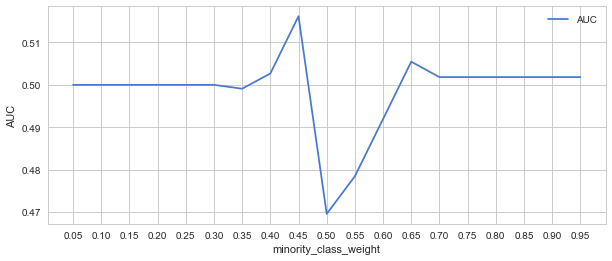

In [33]:
# Best Penalty: l2
# Best C: 3593.813663804626
    
# Plotting AUC by class weight
Compare_AUC_Class_Weight(X_train_US,y_train_US,X_test,y_test,penalty='l2',C=3593.813663804626)
# Best class_weight Area = {1:0.45, 0:0.55}

Selecting best configuration.

Logistic Regression on Upsampled Data 

             precision    recall  f1-score   support

          0       0.10      0.22      0.13        50
          1       0.92      0.81      0.86       549

avg / total       0.85      0.76      0.80       599

Accuracy:  76.29382303839732 %
AUC:  51.61930783242259 %


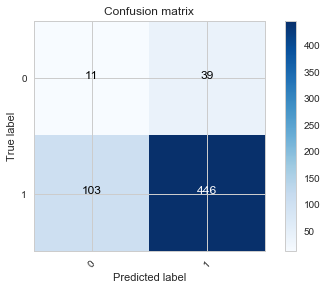

In [38]:
# Best class_weight Area = {1:0.45, 0:0.55}

# all parameters not specified are set to their defaults
logisticRegr = sk.linear_model.LogisticRegression(penalty='l2',C=3593.813663804626,class_weight={0:0.45,1:0.55}, random_state=42)
logisticRegr.fit(X_train_US, y_train_US)

# Predictions
y_pred=logisticRegr.predict(X_test)

# Compute confusion matrix
cnf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')
# Print Metrics
print 'Logistic Regression on Upsampled Data','\n'
print_class_matrics(y_test, y_pred)
plt.show()

**Downsampling**

Hyperparameter tuning to find best configuration for Logistic Regression models.
- Penalty
- Inverse of regularization strength
- Class Weights

In [39]:
# Downsample majority class
train_majority_downsampled = resample(train_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=213,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
train_downsampled = pd.concat([train_majority_downsampled, train_minority])
 
# Display new class counts
train_downsampled.did_buy.value_counts()

# 1    223
# 0    211

#Re-Splitting Data 
y_train_DS=train_downsampled.did_buy
X_train_DS=train_downsampled.drop('did_buy',axis=1)

# Hyperparameter Tuning using Grid Search Cross Validation   
Hyperparameter_Tuning_LR(X_train_DS,y_train_DS)

Best Penalty: l1
Best C: 166.81005372000593


Finding best class  weight while maximizing Area Under Curve.

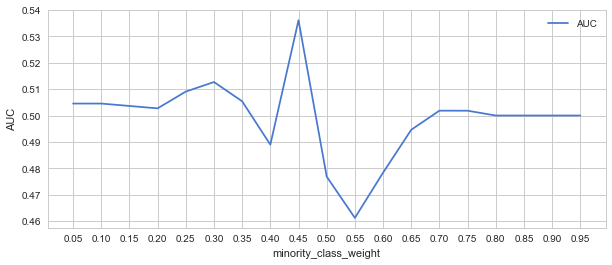

In [40]:
#Plot AUC by class weight
Compare_AUC_Class_Weight(X_train_DS,y_train_DS,X_test,y_test,penalty='l1',C=166.81005372000593)
# Best class_weight Area = {1:0.45, 0:0.55}

Selecting best configuration.

Logistic Regression on Downsampled Data 

             precision    recall  f1-score   support

          0       0.10      0.34      0.16        50
          1       0.92      0.73      0.82       549

avg / total       0.86      0.70      0.76       599

Accuracy:  69.94991652754591 %
AUC:  53.612021857923494 %


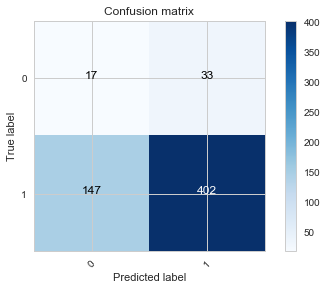

In [41]:
# Best class_weight Area = {1:0.45, 0:0.55}

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(penalty='l1',C=166.81005372000593,class_weight={0:0.45, 1:0.55},random_state=42)
logisticRegr.fit(X_train_DS,y_train_DS)


# Predict for One Observation (image)
y_pred=logisticRegr.predict(X_test)

# Compute confusion matrix
cnf_matrix = sk.metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

# Print Metrics
print 'Logistic Regression on Downsampled Data','\n'
print_class_matrics(y_test, y_pred)
plt.show()

By comparing different Logistic Regression models based on the Area Under Curve metric, we can see that best fit is the **Downsampled Model**. 

<u>Downsampled model details:</u>
- Accuracy:  76.5 %
- AUC:  54.5%  
- Penalty = 'l2'
- C = 2.78255940221
- class_weight = {0:0.4377, 1:0.5723}

#### <font color=blue> Random Forest </font>####

Hyperparameter tuning to find best configuration for Logistic Regression models.
- Number of trees
- Number of features to consider at every split
- Maximum number of levels in tree
- Minimum number of samples required to split a node
- Minimum number of samples required at each leaf node
- Bootstrapping

In [47]:
# Best Random Forest Down Sampling Configuration
Random_Forest_Hyperparameter_Tuning(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.1min finished


{'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_split': 2, 'max_depth': 10}


Selecting best configuration and plotting Confusion Matrix & Metrics.

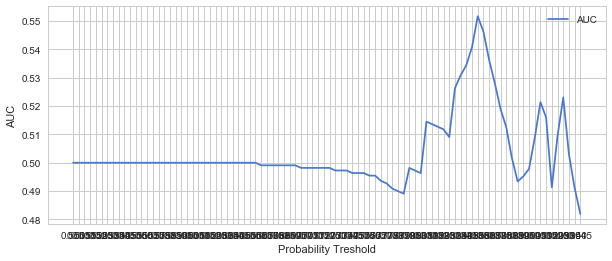

Max AUC:  0.5517304189435337  Probability Treshold:  0.8550000000000003
Optimized Random Forest 

             precision    recall  f1-score   support

          0       0.16      0.20      0.18        50
          1       0.93      0.90      0.91       549

avg / total       0.86      0.84      0.85       599

Accuracy:  84.47412353923205 %
AUC:  55.17304189435337 %


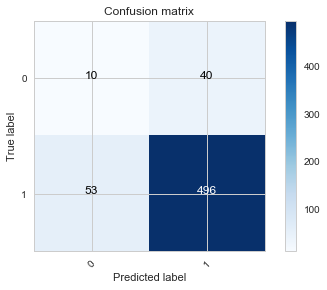

In [48]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import ensemble
# Best Random Forest Down Sampling Configuration
# {'bootstrap': True,
#  'max_depth': 10,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 2,
#  'n_estimators': 400}

best_RF = ensemble.RandomForestRegressor(n_estimators = 400, random_state = 42, 
                                bootstrap=True, max_depth=10, min_samples_leaf=4,
                                min_samples_split=2,max_features='sqrt')


# Train model on training data
best_RF.fit(X_train, y_train);

# Using forest's predict method on the test data
y_pred = best_RF.predict(X_test)

# Finding best treshold
find_Best_RF_Treshold(y_pred)

# Transform Predictions probability to predicted class
predictions=y_pred.copy() 
predictions[predictions >  0.8550000000000003] = 1
predictions[predictions <=  0.8550000000000003] = 0
    
#Printing Classification Results
print 'Optimized Random Forest','\n'
print_class_matrics(y_test, predictions)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(sk.metrics.confusion_matrix(y_test, predictions), classes=['0','1'],title='Confusion matrix')
plt.show()

**Downsampling**

Hyperparameter tuning to find best configuration for Logistic Regression models.

In [49]:
Random_Forest_Hyperparameter_Tuning(X_train_DS, y_train_DS)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished


{'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 400, 'max_features': 'sqrt', 'min_samples_split': 5, 'max_depth': 100}


Finds best classifier treshold while selecting best configuration.

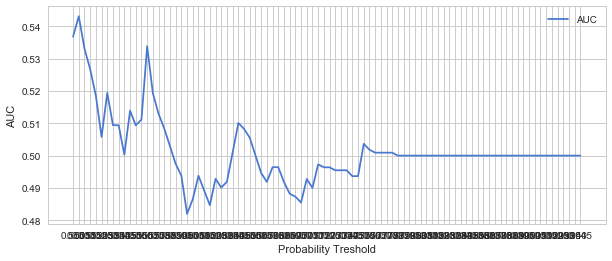

Max AUC:  0.543151183970856  Probability Treshold:  0.505


In [50]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# {'max_depth': 100, 'max_features': 'sqrt', 'min_samples_split': 5, 
#  'min_samples_leaf': 1, 'bootstrap': True, 'n_estimators': 400}

# Instantiate model with 400 decision trees
best_RF = RandomForestRegressor(n_estimators = 400, random_state = 42, 
                                bootstrap=True, max_depth=100, min_samples_leaf=1,
                                min_samples_split=5,max_features='sqrt')

# Train the model on training data
best_RF.fit(X_train_DS,y_train_DS)


# Use the forest's predict method on the test data
y_pred = best_RF.predict(X_test)
find_Best_RF_Treshold(y_pred)

Plotting Confusion Matrix & Metrics.

             precision    recall  f1-score   support

          0       0.10      0.62      0.17        50
          1       0.93      0.47      0.62       549

avg / total       0.86      0.48      0.58       599

Accuracy:  47.91318864774624 %
AUC:  54.315118397085605 %


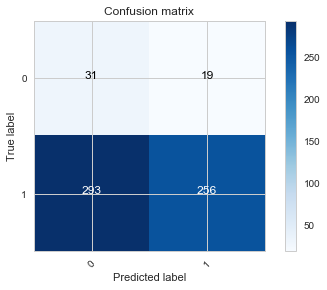

In [51]:
from sklearn import metrics
# Train the model on training data
best_RF.fit(X_train_DS,y_train_DS)


# Use the forest's predict method on the test data
y_pred = best_RF.predict(X_test)
predictions=y_pred.copy()
predictions[predictions >0.505] = 1
predictions[predictions <= 0.505] = 0

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix')

#Printing Classification Results
print_class_matrics(y_test, predictions)
plt.show()

#### <font color=blue> K Nearest Neighbors </font>####

Finding best K who maximize the Area Under Curve metric.

Max AUC:  0.5153734061930783  Best K:  1


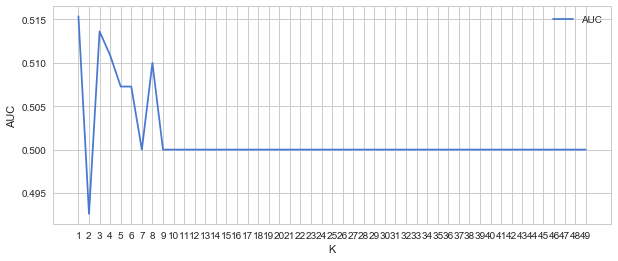

In [71]:
# Load libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Create standardizer
standardizer = StandardScaler()

# Standardize features
X_std_train = standardizer.fit_transform(X_train)
X_std_test = standardizer.fit_transform(X_test)


# # Finding best K for maximizing AUC
finding_best_K(X_std_train,y_train, X_std_test,y_test,max_k=50)

# Implementing KNN with 1 neighbors

KNN with 1 neighbors 

             precision    recall  f1-score   support

          0       0.11      0.12      0.11        50
          1       0.92      0.91      0.91       549

avg / total       0.85      0.84      0.85       599

Accuracy:  84.47412353923205 %
AUC:  51.53734061930783 %


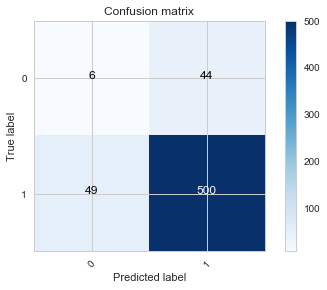

In [73]:
from sklearn import neighbors
# Train a KNN classifier with 1 neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=1).fit(X_std_train, y_train)
        
# Prediction on test data
y_pred = knn.predict(X_std_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],title='Confusion matrix')

#Printing Classification Results
print 'KNN with 1 neighbors','\n'
print_class_matrics(y_test, y_pred)
plt.show()

**Downsampling**

Max AUC:  0.5395264116575591  Best K:  3


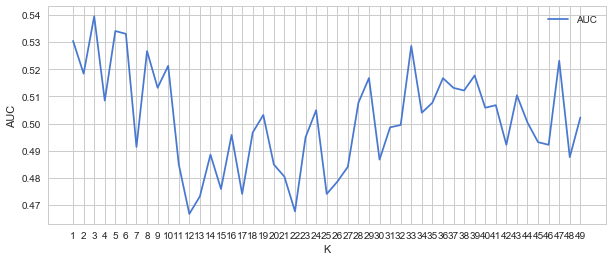

In [76]:
#Downsampled
X_std_train_DS = standardizer.fit_transform(X_train_DS) 
finding_best_K(X_std_train_DS,y_train_DS, X_std_test, y_test, max_k=50)

Implementing KNN with 3 neighbors on downsampled data.

KNN with 3 neighbours on Downsampled Data 

             precision    recall  f1-score   support

          0       0.09      0.60      0.16        50
          1       0.93      0.48      0.63       549

avg / total       0.86      0.49      0.59       599

Accuracy:  48.91485809682805 %
AUC:  53.95264116575591 %


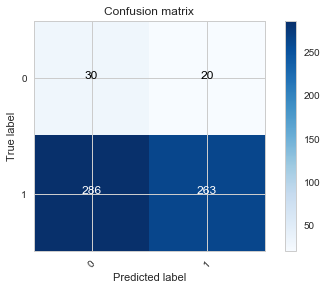

In [77]:
# Train a KNN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1).fit(X_std_train_DS, y_train_DS)
       
# Prediction on test data
y_pred = knn.predict(X_std_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],title='Confusion matrix')

#Printing Classification Results
print 'KNN with 3 neighbours on Downsampled Data','\n'
print_class_matrics(y_test, y_pred)
plt.show()

**Upsampling**

Max AUC:  0.5995810564663023  Best K:  46


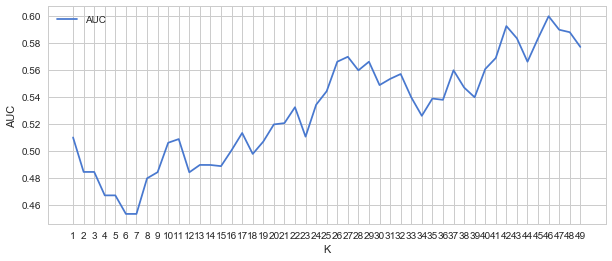

In [62]:
#Upsampled
X_std_train_US = standardizer.fit_transform(X_train_US) 
finding_best_K(X_std_train_US,y_train_US, X_std_test, y_test,max_k=50)

KNN with 46 neighbours on Upsampled Data 

             precision    recall  f1-score   support

          0       0.12      0.66      0.20        50
          1       0.95      0.54      0.69       549

avg / total       0.88      0.55      0.65       599

Accuracy:  54.92487479131887 %
AUC:  59.95810564663023 %


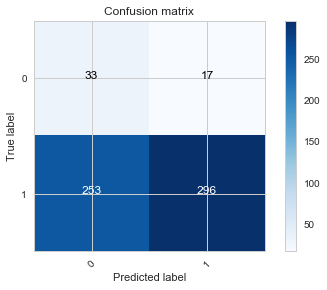

In [78]:
# Train a KNN classifier with 46 neighbors 
knn = KNeighborsClassifier(n_neighbors=46, n_jobs=-1).fit(X_std_train_US, y_train_US)
       
# Prediction on test data
y_pred = knn.predict(X_std_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plotting confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],title='Confusion matrix')

#Printing Classification Results
print 'KNN with 46 neighbours on Upsampled Data','\n'
print_class_matrics(y_test, y_pred)
plt.show()

### <font color=darkgreen>Conclusions</font> ### 

After comparing between different algorithms both by Accuracy and AUC metrics and moreover, because AUC is more suitable metric for imbalanced data problems than Accuracy, we consider that best performed algorithm so far is **KNN classifier with 46 neighbors trained on upsampled data with AUC of ~ 60% & Accuracy of 55%**. However, if we prefer to prioritize Accuracy on AUC, best performed algorithm is **Random Forest (n_estimators = 400, random_state = 42,bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2,max_features='sqrt') with Accuracy of 84.5% & AUC of 55.2% **.



### <font color=darkgreen> Summary </font> ### 


**How can we use the information above in order to increase sales?** 

By classifying potential prospects we can detect new opportunities for engagements and sales promotions. Therefore, steps that can be used wisely in order to increase sales with the above information are the following:

1. Since prospects who are more active in the network are more likely to have more connections with LinkedIn profiles, it's possible to invest in managing campaigns for hardware products in different social networks, analyze and optimize them in order to maximize conversion rate. 

2. Higher exposure among prospects will affect the exposure of their social platforms friends and will result in an increase for new opportunities that could increse conversion rate as well.

3. Locating huge enterprises, offering them special sales or discounts in order to promote sales and to increse clients amount.  

We can consider collecting other features that aren't included in the dataset provided for example, details about prospect's age and gender or other characteristics can be useful. In addition, information about sales products, quantities and prices can deliver more insights. Moreover, by collecting the names of their linkedin shared connections friends we can use Social Network Analysis in order to detect bottle necks, Hubs, Authorities, etc. In addition, extracting reviews from the differnet blogs while using natural language processing techniques can add insights about prospect's satisfaction from both company service and products quality.